# Introduction


"Sentiment analysis is the field of study that analyzes people's sentiments, evaluations, attitudes, and emotions from written language. Sentiment analysis systems are being applied in almost every business and social domain because opinions are central to almost all human activities and are key influencers of our behaviors. Our beliefs and perceptions of reality, and the choices we make, are largely conditioned on how others see and evaluate the world. For this reason, when we need to make a decision we often seek out the opinions of others." [1]

In this notebook, we will analyze 

Source:
[1]. Bing Liu, https://www.morganclaypool.com/doi/abs/10.2200/s00416ed1v01y201204hlt016

# Data

The following datasets were used for this sentiment analysis:

    [1]. given dataset: tweets
    
Additional Datasets:

    [2]. Amazon and Best Buy electronics review dataset: https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics
    [3]. Amazon electronics review dataset: https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics
            

In [1]:
# True if ran in google colab.
GOOGLE_DRIVE = False

In [2]:
# Importing different libraries
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if GOOGLE_DRIVE:
    # Importing data from google drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Importing data from google drive
    df = pd.read_csv("drive/My Drive/dataset/twitter_sentiment/tweet_product_company.csv", 
                     encoding='unicode_escape')
else:
    df = pd.read_csv('data/tweet.csv', encoding='unicode-escape')#, encoding='unicode_escape')

In [4]:
df.columns=['text', 'product', 'target']
df['text'].iloc[-1]

'\x8cÏ¡\x8eÏà\x8aü_\x8b\x81Ê\x8b\x81Î\x8b\x81Ò\x8b\x81£\x8b\x81Á\x8bââ\x8b\x81_\x8b\x81£\x8b\x81\x8f\x8bâ_\x8bÛâRT @mention Google Tests \x89ÛÏCheck-in Offers\x89Û\x9d At #SXSW {link}'

In [5]:
df.shape

(9093, 3)

In [6]:
# Check for class imbalance
df['target'].value_counts(1)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: target, dtype: float64

> There is a great imbalance in class... Possible get around:

    [1] SMOTE - oversampling
    [2] Undersampling - since we do not have many data, we will not use undersampling technique
    [3] class_weight

In [7]:
print(' '.join(df['text'][0:5]))

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW. @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW. @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)


# Round 1: Positive and Negative Emotions Only

## Importing Various Libraries

In [82]:
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

import re
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(0)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juhyunlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


For the first round of modeling, we will solely focus on classifying either positive or negative sentiments from given tweet texts. To do so, we will follow the following steps:

    [1]. Tokenize words using regex
    [2]. Remove any stop words using NLTK and punctuation lists
    [3]. Vectorize words using counter and TF-IDF
    [4]. Train and Evaluate models

In [517]:
# Copies only positive and negative emotions from the dataset
df1 = df[(df['target']=='Positive emotion') | (df['target']=='Negative emotion')].copy()

In [518]:
df1['target'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: target, dtype: int64

## Tokenizing

In [23]:
# Define stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
             'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
             'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
             'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
             'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does' 'did',
             'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
             'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
             'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
             'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
             'again','further', 'then', 'once', 'here', 'there', 'when', 'where',
             'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
             'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
             'can','will','just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y'] + list(string.punctuation)

In [24]:
def process_text(tweet,
                 tokenizer='regex',
                 pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                 stopwords_list=stopwords,
                 lemmatize=True):
    """
    Removes stopwords and tokenizes an input tweet/text.
    
    Args:
        tweet (str): text that needs to be processed
        
        tokenizer (str): chooses different types of tokenizer
                         {'word', 'regex', 'tweet'}
        
        pattern (str): RegEx pattern which will be used to tokenize the input text.
                       Not needed unless tokenizer is set to 'regex'.
        
        stopwords_list (list): List of stopwords that need to be removed from tokens.
    
        lemmatize (bool): True if lemmatize (pos = 'v' by default)
    Return:
        tokens_stopped (list): List of words that are tokenized from input text
    """
    if tokenizer == 'regex':
        # Tokenizes using given regex pattern
        tokens = nltk.regexp_tokenize(tweet, pattern)
        
    elif tokenizer == 'tweet':
        tokens = TweetTokenizer().tokenize(tweet)
        
    elif tokenizer == 'word':
        tokens = word_tokenize(tweet)
    
    # Filters out all the stop words
    if stopwords_list:
        tokens = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    else:
        tokens = [token.lower() for token in tokens if len(token)>1]
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer() 
        tokens = [lemmatizer.lemmatize(x, pos='v') for x in tokens]
        
    return ' '.join(tokens)

In [25]:
# Tokenizes each tweet from dataset
df1['clean_text'] = [process_text(x, stopwords_list=None) for x in df1['text']]

In [527]:
# Dictionary with target variables to shorten their texts
target_dict = {'Negative emotion': 'Negative',
               'Positive emotion': 'Positive',
               'No emotion toward brand or product': 'Neutral'}

# Changes the target text into shorter version
df1['target'] = df1['target'].apply(lambda x: target_dict[x])

Text(0.5, 1.0, 'Positive Words')

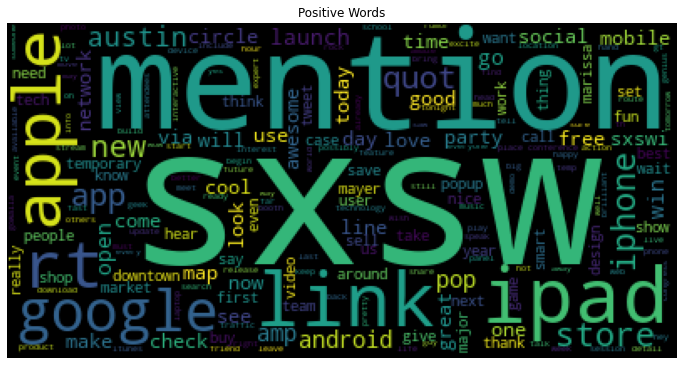

In [27]:
wordcloud = WordCloud(collocations=False)
wordcloud.generate(','.join(df1[df1['target']=='Positive']['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')

Text(0.5, 1.0, 'Positive Words')

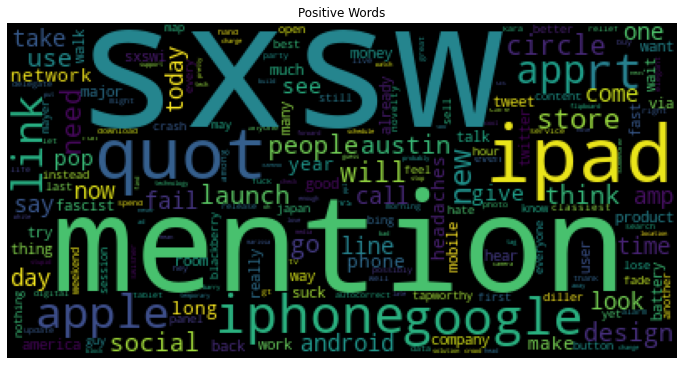

In [28]:
wordcloud = WordCloud(collocations=False)
wordcloud.generate(','.join(df1[df1['target']=='Negative']['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')

In [29]:
stopwords += ['rt', 'sxsw', 'quot', 'ipad', 'iphone', 'mention', 'google', 'apple',
              'link', 'android', 'amp', 'app', 'store', 'austin', 'new', 'get']

Text(0.5, 1.0, 'Positive Words')

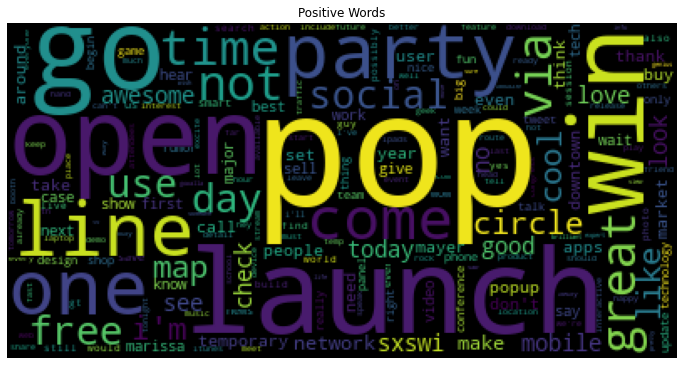

In [30]:
wordcloud = WordCloud(stopwords=stopwords, collocations=False)
wordcloud.generate(','.join(df1[df1['target']=='Positive']['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')

Text(0.5, 1.0, 'Negative Words')

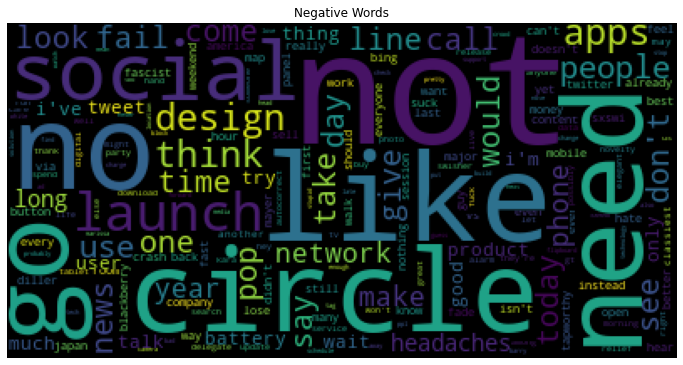

In [31]:
wordcloud = WordCloud(stopwords=stopwords, collocations=False)
wordcloud.generate(','.join(df1[df1['target']=='Negative']['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Negative Words')

In [32]:
# Tokenizes each tweet from dataset
df1['clean_text'] = [process_text(x, stopwords_list=stopwords) for x in df1['clean_text']]

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# Splits the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df1[['clean_text']],
                                                    df1['target'], 
                                                    random_state=42)

# The following function allows us to use alread-tokenized tweets in TF-IDF vectorizer
# Source: https://stackoverflow.com/questions/48671270/use-sklearn-tfidfvectorizer-with-already-tokenized-inputs
# def identity_tokenizer(text):
#     return text
# Word Vectorizer
vectorizer = TfidfVectorizer() #tokenizer=identity_tokenizer, lowercase=False)

X_train_vect = vectorizer.fit_transform(X_train['clean_text'])
X_test_vect = vectorizer.transform(X_test['clean_text'])

## SMOTE

In [35]:
# Oversamples
X_train_vect_smote, y_train_smote = SMOTE().fit_resample(X_train_vect, y_train)

## Models

In [36]:
import src.useful_codes as uc

In [37]:
pd.Series(y_test).value_counts(1)

Positive    0.845547
Negative    0.154453
Name: target, dtype: float64

In [38]:
def run_model(name, params=None, data=None, report=True, classes=['Negative emotion', 'Positive emotion'], model=False):
    """
    Fits and evaluates model
    
    Args:
        name (str, obj): Name of a model OR actual model object.
                        possible names: {'RF', 'XGB', 'NB', 'SVM'}
                    
        params (dict): Dictionary of parameters for the model.
        
        **data (dataframe): X_train, X_test, y_train, y_test
        
        report (bool): True if classification report/confusion matrix is wanted.
        
        classes (list): List of target classes.
        
        model (bool): True if an actual model is added for 'name'.
    
    Returns:
        model (object): fitted model
    """
    if model:
        clf = name
    else:
        if name == 'RF':
            if params:
                clf = RandomForestClassifier(**params)
            else:
                clf = RandomForestClassifier()
        elif name == 'NB':
            if params:
                clf = MultinomialNB(**params)
            else:
                clf = MultinomialNB()
        elif name == 'XGB':
            if params:
                clf = XGBClassifier(**params)
            else:
                clf = XGBClassifier()
        elif name == 'SVM':
            if params:
                clf = LinearSVC(**params)
            else:
                clf = LinearSVC()
        elif name == 'LR':
            if params:
                clf = LogisticRegression(**params)
            else:
                clf = LogisticRegression()
    
    clf.fit(data['X_train'], data['y_train'])
    
    if report:
        uc.evaluate_clf_model(clf, data['X_train'], data['y_train'],
                              data['X_test'], data['y_test'],
                              classes=classes,
                              label=f'{name} Classifier');
    return clf

### Random Forest

------------------------------------------------------------
[i] CLASSIFICATION REPORT RF Classifier
------------------------------------------------------------
Train Accuracy :  0.9989
Test Accuracy :  0.8884
                  precision    recall  f1-score   support

Negative emotion       0.87      0.33      0.48       137
Positive emotion       0.89      0.99      0.94       750

        accuracy                           0.89       887
       macro avg       0.88      0.66      0.71       887
    weighted avg       0.89      0.89      0.87       887

------------------------------------------------------------




RandomForestClassifier()

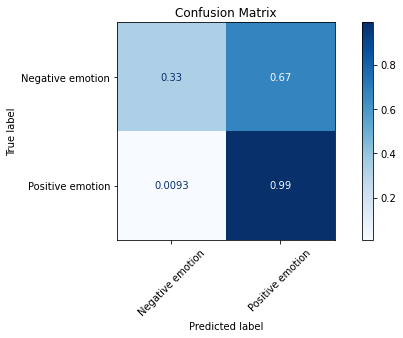

In [39]:
run_model(name='RF',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT RF Classifier
------------------------------------------------------------
Train Accuracy :  0.9993
Test Accuracy :  0.8929
                  precision    recall  f1-score   support

Negative emotion       0.83      0.39      0.53       137
Positive emotion       0.90      0.99      0.94       750

        accuracy                           0.89       887
       macro avg       0.86      0.69      0.73       887
    weighted avg       0.89      0.89      0.88       887

------------------------------------------------------------




RandomForestClassifier()

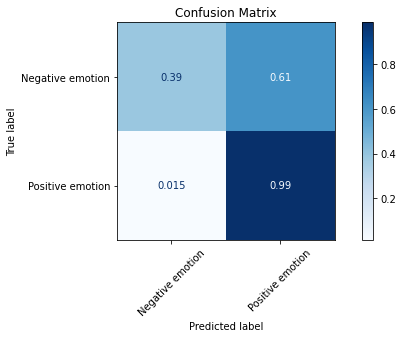

In [40]:
run_model(name='RF',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

### Multinomial Naive Bayes

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.8636
Test Accuracy :  0.8534
                  precision    recall  f1-score   support

Negative emotion       1.00      0.05      0.10       137
Positive emotion       0.85      1.00      0.92       750

        accuracy                           0.85       887
       macro avg       0.93      0.53      0.51       887
    weighted avg       0.88      0.85      0.79       887

------------------------------------------------------------




MultinomialNB()

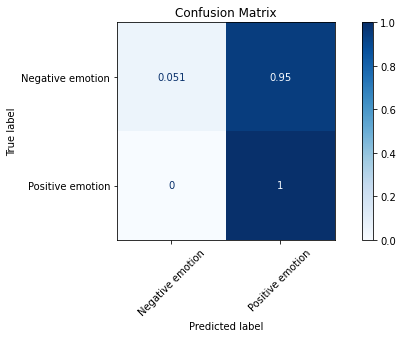

In [41]:
run_model(name='NB',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.9509
Test Accuracy :  0.8005
                  precision    recall  f1-score   support

Negative emotion       0.41      0.69      0.52       137
Positive emotion       0.94      0.82      0.87       750

        accuracy                           0.80       887
       macro avg       0.67      0.76      0.70       887
    weighted avg       0.86      0.80      0.82       887

------------------------------------------------------------




MultinomialNB()

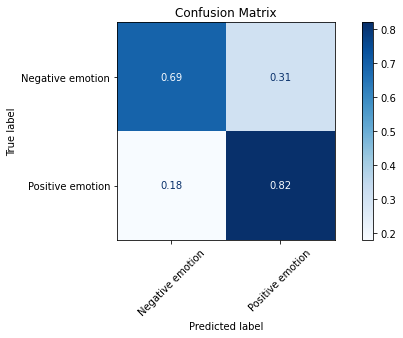

In [42]:
run_model(name='NB',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

### XGBoost

------------------------------------------------------------
[i] CLASSIFICATION REPORT XGB Classifier
------------------------------------------------------------
Train Accuracy :  0.8707
Test Accuracy :  0.8602
                  precision    recall  f1-score   support

Negative emotion       0.78      0.13      0.23       137
Positive emotion       0.86      0.99      0.92       750

        accuracy                           0.86       887
       macro avg       0.82      0.56      0.57       887
    weighted avg       0.85      0.86      0.82       887

------------------------------------------------------------




XGBClassifier()

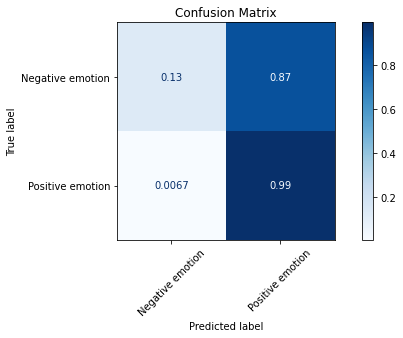

In [43]:
run_model(name='XGB',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT XGB Classifier
------------------------------------------------------------
Train Accuracy :  0.8829
Test Accuracy :  0.8579
                  precision    recall  f1-score   support

Negative emotion       0.56      0.36      0.44       137
Positive emotion       0.89      0.95      0.92       750

        accuracy                           0.86       887
       macro avg       0.73      0.66      0.68       887
    weighted avg       0.84      0.86      0.85       887

------------------------------------------------------------




XGBClassifier()

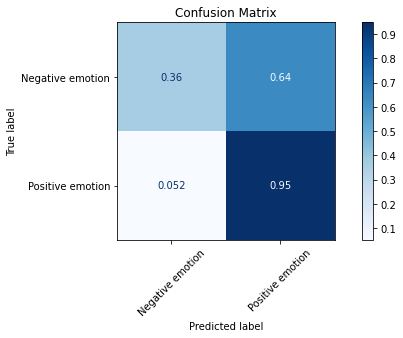

In [44]:
run_model(name='XGB',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

### Support Vector Machine

------------------------------------------------------------
[i] CLASSIFICATION REPORT SVM Classifier
------------------------------------------------------------
Train Accuracy :  0.9929
Test Accuracy :  0.8918
                  precision    recall  f1-score   support

Negative emotion       0.73      0.48      0.58       137
Positive emotion       0.91      0.97      0.94       750

        accuracy                           0.89       887
       macro avg       0.82      0.72      0.76       887
    weighted avg       0.88      0.89      0.88       887

------------------------------------------------------------




LinearSVC()

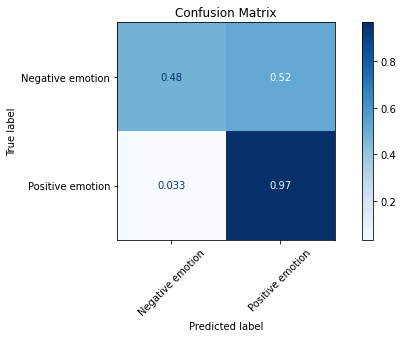

In [45]:
run_model(name='SVM',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT SVM Classifier
------------------------------------------------------------
Train Accuracy :  0.9964
Test Accuracy :  0.8681
                  precision    recall  f1-score   support

Negative emotion       0.57      0.59      0.58       137
Positive emotion       0.92      0.92      0.92       750

        accuracy                           0.87       887
       macro avg       0.75      0.75      0.75       887
    weighted avg       0.87      0.87      0.87       887

------------------------------------------------------------




LinearSVC()

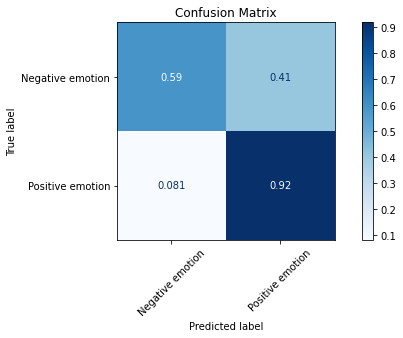

In [46]:
run_model(name='SVM',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

### Logistic Regression

------------------------------------------------------------
[i] CLASSIFICATION REPORT LR Classifier
------------------------------------------------------------
Train Accuracy :  0.8613
Test Accuracy :  0.8534
                  precision    recall  f1-score   support

Negative emotion       0.82      0.07      0.12       137
Positive emotion       0.85      1.00      0.92       750

        accuracy                           0.85       887
       macro avg       0.84      0.53      0.52       887
    weighted avg       0.85      0.85      0.80       887

------------------------------------------------------------




LogisticRegression()

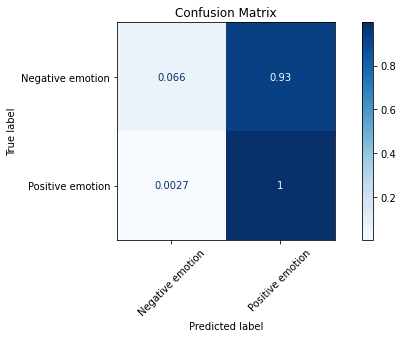

In [47]:
run_model(name='LR',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT LR Classifier
------------------------------------------------------------
Train Accuracy :  0.9677
Test Accuracy :  0.8455
                  precision    recall  f1-score   support

Negative emotion       0.50      0.59      0.54       137
Positive emotion       0.92      0.89      0.91       750

        accuracy                           0.85       887
       macro avg       0.71      0.74      0.72       887
    weighted avg       0.86      0.85      0.85       887

------------------------------------------------------------




LogisticRegression()

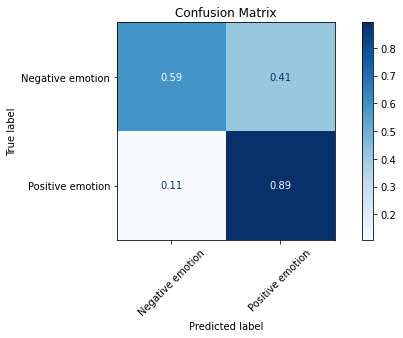

In [48]:
run_model(name='LR',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

### Conclusion

> Generally, models with SMOTE data did better in recalls for negative emotions compared to the normal dataset.

Since we want to ultimately add in `neutral` sentiment into our dataset, we will not tune the models just yet.

# Round 2: Using Spacy

This time, we will include neutral emotions and see how our models would do.

In [519]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [520]:
def clean_text(text):
    """
    Cleans and tokenizes tweet text data.
    Args:
        text (str): tweet text data
    
    Returns:
        tokens
    """
    text = re.sub(r'@\S+', '', text) # Gets rid of any mentions
    text = re.sub(r'RT\S+', '', text) # Gets rid of any retweets
    text = re.sub(r'#', '', text) # Gets rid of hashtag sign
    text = re.sub(r'https?:\/\/\S+', '', text) # Gets rid of any links
    text = re.sub(r'[0-9]+.?[0-9]+', '', text) # Gets rid of X.X where X are numbers
    text = re.sub(r'#?[sSxX]\S+', '', text) # Gets rid common mentions
    text = re.sub(r'quote\S+', '', text)
    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-': # if token is not a pronoun
            temp_token = token.lemma_.lower().strip()
        else:
            temp_token = token.lower_
        tokens.append(temp_token)
    
    tokens_stopped = [token for token in tokens if token not in stopwords_list and len(token)>2]
    
    return tokens_stopped


In [528]:
# Takes data with positive, negative and neutral sentiments.
df1

,text,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive


## Preprocessing

In [687]:
X = df1['text']
y = df1['target']

In [688]:
pd.Series(y).value_counts()

Positive    2978
Negative     570
Name: target, dtype: int64

In [530]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [525]:
tfidf = TfidfVectorizer(tokenizer=clean_text)

In [524]:
lr = LogisticRegression(class_weight='balanced')

In [526]:
# Creates Pipeline
sentiment_clf = Pipeline([('tfidf', tfidf),
                          ('clf', lr)])

## Models

In [531]:
sentiment_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function clean_text at 0x1a21aed6a8>)),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [533]:
y_pred = sentiment_clf.predict(X_test)

              precision    recall  f1-score   support

    Negative       0.49      0.66      0.56       115
    Positive       0.93      0.87      0.90       595

    accuracy                           0.83       710
   macro avg       0.71      0.76      0.73       710
weighted avg       0.86      0.83      0.84       710



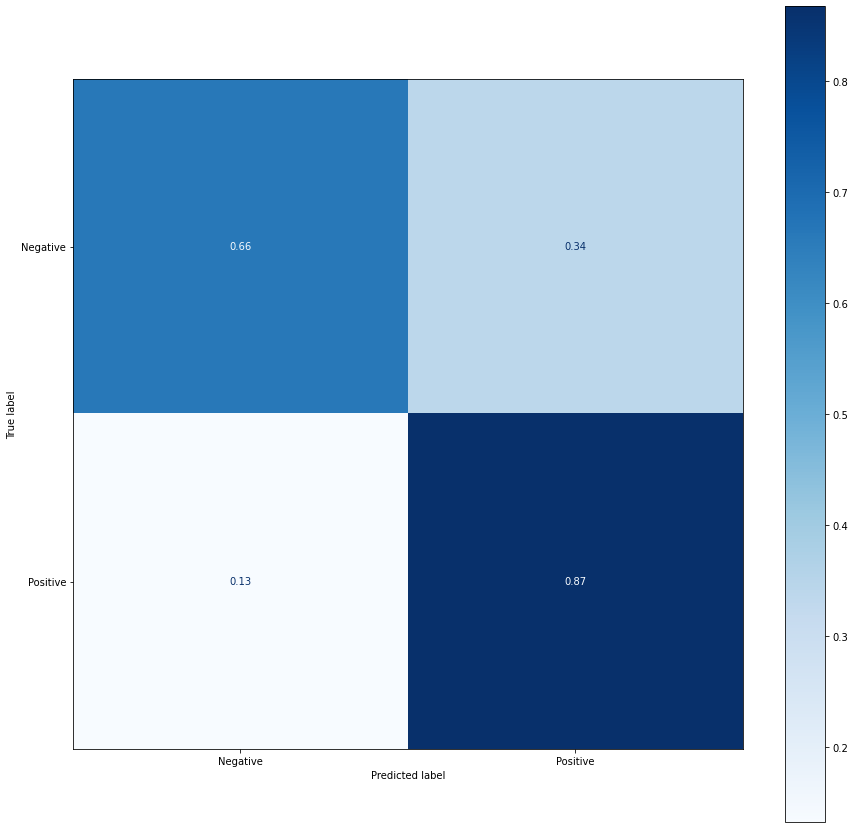

In [537]:
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(sentiment_clf, X_test, y_test, normalize='true', ax=ax, cmap='Blues')

### Conclusion

It seems likes `LogisticRegression`, `Support Vector Machine` and `Multinomial Naive Bayes` models are doing the 'best'.

# Round 3: Multiclass

In [612]:
# Dictionary with target variables to shorten their texts
target_dict = {'Negative emotion': 'Negative',
               'Positive emotion': 'Positive',
               'No emotion toward brand or product': 'Neutral'}

# Changes the target text into shorter version
df['target'] = [target_dict[x] if x in target_dict.keys() else x for x in df['target']]

In [613]:
from spacy.lang.en import STOP_WORDS
stopwords_list = list(STOP_WORDS) + list(string.punctuation)+['link', 'amp'] # + ['app']

In [622]:
def clean_text(text):
    """
    Cleans and tokenizes tweet text data.
    Args:
        text (str): tweet text data
    
    Returns:
        tokens
    """
    text = re.sub(r'@\S+', '', text) # Gets rid of any mentions
    text = re.sub(r'RT\S+', '', text) # Gets rid of any retweets
    text = re.sub(r'#', '', text) # Gets rid of hashtag sign
    text = re.sub(r'https?:\/\/\S+', '', text) # Gets rid of any links
    text = re.sub(r'[0-9]+.?[0-9]+', '', text) # Gets rid of X.X where X are numbers
    text = re.sub(r'#?[sSxX]\S+', '', text) # Gets rid common mentions
    text = re.sub(r'[Qquot]\S+', '', text) # Gets rid of quotes
    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-': # if token is not a pronoun
            temp_token = token.lemma_.lower().strip()
        else:
            temp_token = token.lower_
        tokens.append(temp_token)
    
    tokens_stopped = [token for token in tokens if token not in stopwords_list and len(token)>2]
    
    return tokens_stopped


In [623]:
df3 = df[df['target'] != "I can't tell"][['text', 'target']].copy()

In [624]:
df3.dropna(inplace=True)

In [625]:
X = df3['text']
y = df3['target']

In [626]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [627]:
lr = LogisticRegression(class_weight = 'balanced')
multi_sentiment_clf = Pipeline([('tfidf', tfidf),
                                 ('clf', lr)])


In [628]:
multi_sentiment_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function clean_text at 0x1a21aed6a8>)),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [629]:
y_pred = multi_sentiment_clf.predict(X_test)

In [631]:
pd.Series(y).value_counts(1)

Neutral     0.602954
Positive    0.333259
Negative    0.063787
Name: target, dtype: float64

In [648]:
accuracy_score(y_train, multi_sentiment_clf.predict(X_train))

0.7883324006715166

In [650]:
print(classification_report(y_train, multi_sentiment_clf.predict(X_train)))

              precision    recall  f1-score   support

    Negative       0.54      0.97      0.70       444
     Neutral       0.88      0.77      0.82      4294
    Positive       0.73      0.79      0.76      2410

    accuracy                           0.79      7148
   macro avg       0.72      0.84      0.76      7148
weighted avg       0.81      0.79      0.79      7148



              precision    recall  f1-score   support

    Negative       0.33      0.53      0.41       126
     Neutral       0.78      0.66      0.72      1094
    Positive       0.54      0.62      0.58       568

    accuracy                           0.64      1788
   macro avg       0.55      0.61      0.57      1788
weighted avg       0.67      0.64      0.65      1788



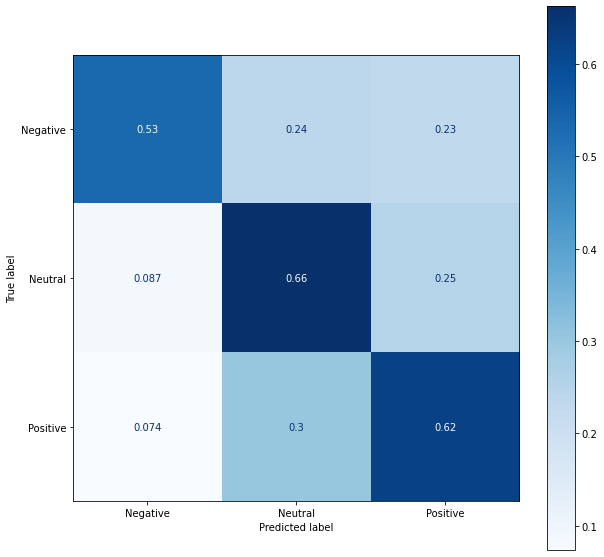

In [630]:
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(multi_sentiment_clf, X_test, y_test, normalize='true', ax=ax, cmap='Blues')

In [632]:
y_prob = multi_sentiment_clf.predict_proba(X_test)

In [633]:
y_prob

array([[0.4932664 , 0.38012669, 0.12660691],
       [0.1956969 , 0.33015981, 0.47414329],
       [0.05764825, 0.48107719, 0.46127457],
       ...,
       [0.18475709, 0.58038795, 0.23485496],
       [0.03906798, 0.25745964, 0.70347237],
       [0.15687796, 0.21521477, 0.62790727]])

In [646]:
threshold_df = pd.DataFrame(y_prob, columns = ['neg_prob', 'neu_prob', 'pos_prob'])
threshold_df['target'] = list(y_test)
threshold_df['predict'] = list(y_pred)
threshold_df['text'] = list(X_test)
threshold_df['token'] = list(X_test.apply(clean_text))

In [639]:
threshold_df[(threshold_df['target']=='Neutral') & (threshold_df['predict']!='Neutral')]

,neg_prob,neu_prob,pos_prob,target,predict,text,token
0,0.493266,0.380127,0.126607,Neutral,Negative,ÛÏ@mention Google doesn't place any value on ...,"[ûï, place, val]"
1,0.195697,0.330160,0.474143,Neutral,Positive,"RT @mention One minute ago, the guy I spoke ou...","[min, apple, hand, ipad, wai, ...]"
8,0.400544,0.331272,0.268185,Neutral,Negative,I had to pull out my iPhone and look busy to f...,"[iph, fit, badge, line]"
14,0.082550,0.102345,0.815104,Neutral,Positive,#SXSW #apple store just sold their last #ipad,"[apple, ipad]"
15,0.504206,0.359107,0.136688,Neutral,Negative,RT @mention Google (tries again) to launch a n...,"[new, circle]"
...,...,...,...,...,...,...,...
1771,0.082944,0.178916,0.738140,Neutral,Positive,"If you got a view master last night, we can't ...","[view, nigh, wait, win, ipad]"
1773,0.129863,0.245512,0.624625,Neutral,Positive,#SXSW Apple Pop Up Store still has iPads in st...,"[apple, ipad, wai, line, apple, ipad2û]"
1777,0.127082,0.334065,0.538853,Neutral,Positive,Grab the latest @mention before #SXSW! {link},"[grab, bef]"
1783,0.038999,0.161779,0.799222,Neutral,Positive,Thanks to everyone for making it a great day i...,"[thank, great, day]"


In [644]:
threshold_df['text'].iloc[15]

'RT @mention Google (tries again) to launch a new social network called Circles: {link} #sxsw'

In [667]:
threshold = 0.5

In [653]:
threshold_df['test'] = (abs(threshold_df['neg_prob']-threshold_df['neu_prob'])<threshold) | \
                       (abs(threshold_df['pos_prob']-threshold_df['neu_prob'])<threshold) 

In [658]:
threshold_df['new_predict'] = ['Neutral' if x else y for x, y in zip(threshold_df['test'], threshold_df['predict'])] 

In [660]:
accuracy_score(threshold_df['target'], threshold_df['predict'])

0.6403803131991052

In [661]:
from sklearn.metrics import confusion_matrix

In [664]:
confusion_matrix(threshold_df['target'], threshold_df['predict'], normalize='true')

array([[0.53174603, 0.23809524, 0.23015873],
       [0.08683729, 0.66270567, 0.25045704],
       [0.07394366, 0.30457746, 0.62147887]])

In [669]:
confusion_matrix(threshold_df['target'], threshold_df['new_predict'], normalize='true')[1][1]

0.9058500914076782

In [678]:
neg_recalls = []
neu_recalls = []
pos_recalls = []
thresholds = np.linspace(0,0.1, 9)
thresholds

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   ])

In [679]:
for threshold in thresholds:
    threshold_df['test'] = (abs(threshold_df['neg_prob']-threshold_df['neu_prob'])<threshold) | \
                       (abs(threshold_df['pos_prob']-threshold_df['neu_prob'])<threshold) 
    threshold_df['new_predict'] = ['Neutral' if x else y for x, y in zip(threshold_df['test'], threshold_df['predict'])] 
    conf = confusion_matrix(threshold_df['target'], threshold_df['new_predict'], normalize='true')
    neg_recalls.append(conf[0][0])
    neu_recalls.append(conf[1][1])
    pos_recalls.append(conf[2][2])

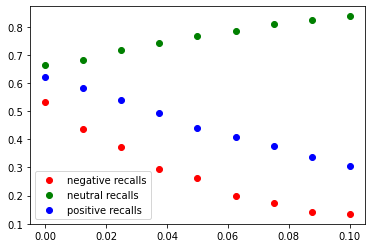

In [684]:
plt.scatter(x=thresholds, y=neg_recalls, linestyle='-', label='negative recalls', color='r')
plt.scatter(x=thresholds, y=neu_recalls, linestyle='-', label='neutral recalls', color='g')
plt.scatter(x=thresholds, y=pos_recalls, linestyle='-', label='positive recalls', color='b')
plt.legend()

# Round 4: Multiclass using N-gram

In [689]:
# Dictionary with target variables to shorten their texts
target_dict = {'Negative emotion': 'Negative',
               'Positive emotion': 'Positive',
               'No emotion toward brand or product': 'Neutral'}

# Changes the target text into shorter version
df['target'] = [target_dict[x] if x in target_dict.keys() else x for x in df['target']]

In [690]:
from spacy.lang.en import STOP_WORDS
stopwords_list = list(STOP_WORDS) + list(string.punctuation)+['link', 'amp'] # + ['app']

In [691]:
def clean_text(text):
    """
    Cleans and tokenizes tweet text data.
    Args:
        text (str): tweet text data
    
    Returns:
        tokens
    """
    text = re.sub(r'@\S+', '', text) # Gets rid of any mentions
    text = re.sub(r'RT\S+', '', text) # Gets rid of any retweets
    text = re.sub(r'#', '', text) # Gets rid of hashtag sign
    text = re.sub(r'https?:\/\/\S+', '', text) # Gets rid of any links
    text = re.sub(r'[0-9]+.?[0-9]+', '', text) # Gets rid of X.X where X are numbers
    text = re.sub(r'#?[sSxX]\S+', '', text) # Gets rid common mentions
    text = re.sub(r'[Qquot]\S+', '', text) # Gets rid of quotes
    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-': # if token is not a pronoun
            temp_token = token.lemma_.lower().strip()
        else:
            temp_token = token.lower_
        tokens.append(temp_token)
    
    tokens_stopped = [token for token in tokens if token not in stopwords_list and len(token)>2]
    
    return tokens_stopped


In [692]:
df4 = df[df['target'] != "I can't tell"][['text', 'target']].copy()

In [693]:
df4.dropna(inplace=True)

In [695]:
X = df4['text']
y = df4['target']

In [702]:
pd.Series(y).value_counts()

Neutral     5388
Positive    2978
Negative     570
Name: target, dtype: int64

In [696]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [708]:
tfidf = TfidfVectorizer(tokenizer=clean_text,
                        ngram_range=(1,2))

In [709]:
lr = LogisticRegression(class_weight = 'balanced')

In [710]:
multi_ngram_sentiment_clf = Pipeline([('tfidf', tfidf),
                                 ('clf', lr)])

In [711]:
multi_ngram_sentiment_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function clean_text at 0x1a3624d510>)),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [712]:
y_test_pred = multi_ngram_sentiment_clf.predict(X_test)
y_train_pred = multi_ngram_sentiment_clf.predict(X_train)

Train accuracy:  0.8353385562395076
Test accuracy:  0.610178970917226
              precision    recall  f1-score   support

    Negative       0.33      0.48      0.39       126
     Neutral       0.74      0.64      0.69      1094
    Positive       0.50      0.58      0.54       568

    accuracy                           0.61      1788
   macro avg       0.52      0.57      0.54      1788
weighted avg       0.64      0.61      0.62      1788



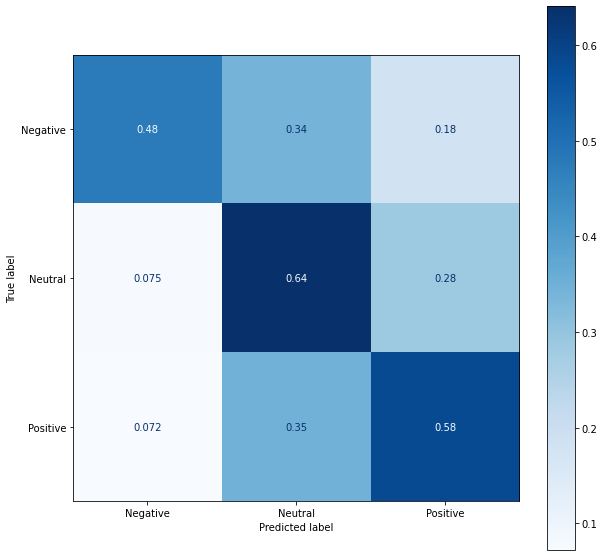

In [713]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(multi_ngram_sentiment_clf, X_test, y_test, normalize='true', ax=ax, cmap='Blues')

# Using Additional Dataset

We have seen that we have a couple of problems with the given dataset:
    
    [1]. Imbalance
    
            No emotion toward brand or product    0.592654
            Positive emotion                      0.327505
            Negative emotion                      0.062686
            I can't tell                          0.017156
            
    [2]. Relatively small data size: 9093 rows
    * The total number of rows may seem like it's a reasonable number, but considering its class imbalance, the number is quite small.

So, to get around this, what we will do is that we will implement a dataset that contains electronic reviews from Amazon and BestBuy.

*Reminder: This dataset can be obtained at https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics

In [714]:
# Import the new dataset
amazon = pd.read_csv('data/amazon_review.csv')

In [242]:
amazon.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


## Preprocessing

In [243]:
amazon = amazon[['reviews.text', 'reviews.rating']]
amazon.columns = ['text', 'rating']

In [244]:
# Drops any Null rows
amazon.dropna(inplace=True)

In [245]:
amazon['rating'].value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: rating, dtype: int64

In [246]:
# Dictionary to change numerical rating into sentiment rating
score_dict = {5.0:'Positive', 4.0:'Positive', 
              3.0:'Neutral', 
              2.0:'Negative', 1.0:'Negative'}

In [247]:
# Converts numerical rating to categorical
amazon['target'] = amazon['rating'].apply(lambda x: score_dict[x])

<AxesSubplot:>

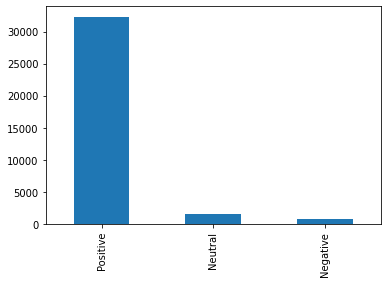

In [248]:
# Visualize distribution of different sentiments
amazon['target'].value_counts().plot.bar()

> Still imbalance in class; however, the number of negative and neutral sentiment reviews are more than what we have in the actual dataset.

In [249]:
def preprocess_comp(data1, data2, text='text', target='target', random_state=42, imbalance=''):
    # Tokenizes each tweet from dataset
    data1['clean_text'] = [process_text(x, stopwords_list=None) for x in data1[text]]
    data2['clean_text'] = [process_text(x, stopwords_list=None) for x in data2[text]]
    
    # Splits the data into train and test set
    X_train, X_veri, y_train, y_veri = train_test_split(data1[['clean_text']],
                                                        data1[target], 
                                                        random_state=random_state)

    # Word Vectorizer
    #vectorizer = TfidfVectorizer() #tokenizer=identity_tokenizer, lowercase=False)
    vectorizer = CountVectorizer(ngram_range=(1,2), max_df=0.5)
    
    X_train_vect = vectorizer.fit_transform(X_train['clean_text'])
    X_veri_vect = vectorizer.transform(X_veri['clean_text'])
    X_test_vect = vectorizer.transform(data2['clean_text'])
    y_test = data2['target']
    
    if imbalance=='smote':
        # Oversamples
        X_train_vect, y_train = SMOTE().fit_resample(X_train_vect, y_train)
    elif imbalance=='undersample':
        rus = RandomUnderSampler(random_state=random_state)
        X_train_vect, y_train = rus.fit_resample(X_train_vect, y_train)
    
    return X_train_vect, X_veri_vect, X_test_vect, y_train, y_veri, y_test

In [250]:
X_train_vect, X_veri_vect, X_test_vect, y_train, y_veri, y_test = preprocess_comp(amazon, df3)

In [251]:
pd.Series(y_train).value_counts()

Positive    24211
Neutral      1143
Negative      615
Name: target, dtype: int64

## Models

### NB

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.949
Test Accuracy :  0.9362
              precision    recall  f1-score   support

    Negative       1.00      0.01      0.01       197
     Neutral       0.40      0.01      0.01       356
    Positive       0.94      1.00      0.97      8104

    accuracy                           0.94      8657
   macro avg       0.78      0.34      0.33      8657
weighted avg       0.92      0.94      0.91      8657

------------------------------------------------------------


------------------------------------------------------------
[i] CLASSIFICATION REPORT NB
------------------------------------------------------------
Train Accuracy :  0.949
Test Accuracy :  0.3336
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       570
     Neutral       0.67      0.00     

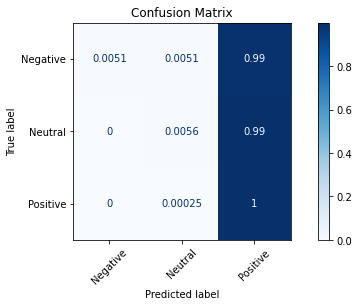

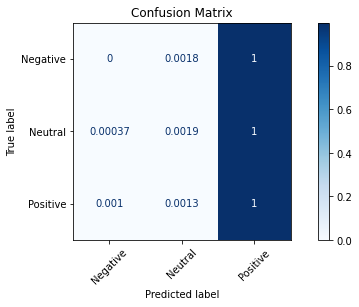

In [252]:
nb_clf = run_model(name='NB',
                   data={'X_train': X_train_vect, 'X_test': X_veri_vect, 
                         "y_train": y_train, 'y_test': y_veri},
                   classes=['Negative', 'Neutral', 'Positive']);

uc.evaluate_clf_model(nb_clf, X_train_vect, y_train,
                      X_test_vect, y_test,
                      classes=['Negative', 'Neutral', 'Positive'],
                      label='NB');


### SVM

------------------------------------------------------------
[i] CLASSIFICATION REPORT SVM Classifier
------------------------------------------------------------
Train Accuracy :  0.9998
Test Accuracy :  0.9314
              precision    recall  f1-score   support

    Negative       0.54      0.30      0.39       197
     Neutral       0.28      0.19      0.23       356
    Positive       0.96      0.98      0.97      8104

    accuracy                           0.93      8657
   macro avg       0.59      0.49      0.53      8657
weighted avg       0.92      0.93      0.92      8657

------------------------------------------------------------


------------------------------------------------------------
[i] CLASSIFICATION REPORT NB
------------------------------------------------------------
Train Accuracy :  0.9998
Test Accuracy :  0.3371
              precision    recall  f1-score   support

    Negative       0.27      0.03      0.05       570
     Neutral       0.57      0.01  

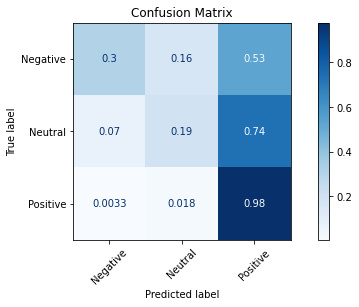

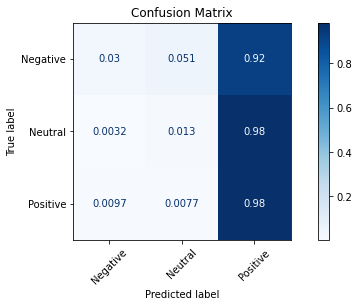

In [253]:
nb_clf = run_model(name='SVM',
          data={'X_train': X_train_vect, 'X_test': X_veri_vect, 
                "y_train": y_train, 'y_test': y_veri},
          classes=['Negative', 'Neutral', 'Positive']);

uc.evaluate_clf_model(nb_clf, X_train_vect, y_train,
                      X_test_vect, y_test,
                      classes=['Negative', 'Neutral', 'Positive'],
                      label='NB');


### Logistic Regression

------------------------------------------------------------
[i] CLASSIFICATION REPORT LR Classifier
------------------------------------------------------------
Train Accuracy :  0.9981
Test Accuracy :  0.937
              precision    recall  f1-score   support

    Negative       0.55      0.26      0.35       197
     Neutral       0.35      0.15      0.21       356
    Positive       0.95      0.99      0.97      8104

    accuracy                           0.94      8657
   macro avg       0.62      0.47      0.51      8657
weighted avg       0.92      0.94      0.92      8657

------------------------------------------------------------


------------------------------------------------------------
[i] CLASSIFICATION REPORT NB
------------------------------------------------------------
Train Accuracy :  0.9981
Test Accuracy :  0.3344
              precision    recall  f1-score   support

    Negative       0.32      0.01      0.02       570
     Neutral       0.56      0.00    

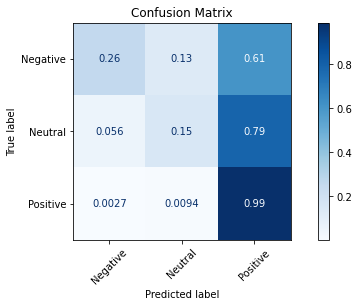

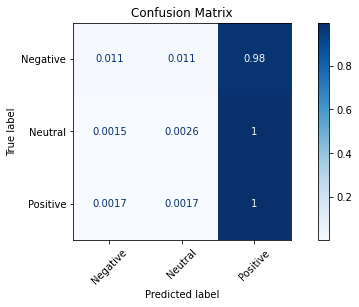

In [254]:
lr_clf = run_model(name='LR',
          data={'X_train': X_train_vect, 'X_test': X_veri_vect, 
                "y_train": y_train, 'y_test': y_veri},
          classes=['Negative', 'Neutral', 'Positive']);

uc.evaluate_clf_model(lr_clf, X_train_vect, y_train,
                      X_test_vect, y_test,
                      classes=['Negative', 'Neutral', 'Positive'],
                      label='NB');


# Using Deep Learning

# Identifying Product Names

In [179]:
import spacy
from spacy import displacy

In [180]:
nlp = spacy.load('en_core_web_sm')

In [488]:
product_df = df.dropna().copy()

In [489]:
product_df

,text,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [490]:
product_df['product'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [491]:
product_dict = {'iPad or iPhone App': 'Apple', 
                'Other Google product or service': 'Google',
                'Other Apple product or service': 'Apple'}

In [492]:
product_df['product'] = [product_dict[x] if x in product_dict.keys() else x for x in product_df['product']]

In [493]:
product_df['product'].unique()

array(['iPhone', 'Apple', 'iPad', 'Google', 'Android', 'Android App'],
      dtype=object)

In [494]:
from spacy.lang.en import STOP_WORDS
stopwords_list = list(STOP_WORDS) + list(string.punctuation)# + ['app']

In [495]:
def clean_text(text):
    text = re.sub(r'@\S+', '', text) # Gets rid of any mentions
    text = re.sub(r'RT\S+', '', text) # Gets rid of any retweets
    text = re.sub(r'#', '', text) # Gets rid of hashtag sign
    text = re.sub(r'https?:\/\/\S+', '', text) # Gets rid of any links
    text = re.sub(r'[0-9]+.?[0-9]+', '', text) # Gets rid of X.X where X are numbers
    text = re.sub(r'#?[sSxX]\S+', '', text) # Gets rid of X.X where X are numbers

    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-': # if token is not a pronoun
            temp_token = token.lemma_.lower().strip()
        else:
            temp_token = token.lower_
        tokens.append(temp_token)
    
    tokens_stopped = [token for token in tokens if token not in stopwords_list and len(token)>2]
    
    return tokens_stopped


In [496]:
sample_text = product_df['text'].iloc[0]
print(sample_text)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


In [497]:
X = product_df['text']
y = product_df['product']

In [498]:
pd.Series(y).value_counts(1)

Apple          0.354300
iPad           0.287451
Google         0.219690
iPhone         0.090246
Android App    0.024613
Android        0.023701
Name: product, dtype: float64

In [499]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [500]:
tfidf = TfidfVectorizer(tokenizer=clean_text)

In [501]:
X_train

8246    Excitement in the social network space with Go...
8969    #SXSW: Day 1. As expected, everyone is glued t...
8972    Biomimicry as the basis of design and problem ...
1118    {link} At SXSW, Apple schools the marketing ex...
7352    Smart company...Apple to set to open pop-up sh...
                              ...                        
2849    Nice to see the speaker sneak in an irrelevant...
2944    Thanks @mention for giving me new top cover fo...
3386    #technology Before It Even Begins, #Apple Wins...
2245    Google web fonts...pretty... #sxsw #tradeshow ...
8771    Thank heavens for nice travelers. Got a iPhone...
Name: text, Length: 2632, dtype: object

In [502]:
lr = LogisticRegression(class_weight='balanced')
svc = LinearSVC()

In [503]:
clf = Pipeline([('tfidf', tfidf),
                ('clf', lr)])

In [504]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function clean_text at 0x1a2060ed90>)),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [505]:
y_pred = clf.predict(X_test)

In [506]:
accuracy_score(y_test, y_pred)

0.8907435508345979

              precision    recall  f1-score   support

     Android       0.62      0.77      0.69        13
 Android App       0.39      0.70      0.50        10
       Apple       0.92      0.81      0.86       239
      Google       1.00      0.99      0.99       141
        iPad       0.90      0.93      0.92       204
      iPhone       0.72      0.94      0.82        52

    accuracy                           0.89       659
   macro avg       0.76      0.86      0.80       659
weighted avg       0.90      0.89      0.89       659



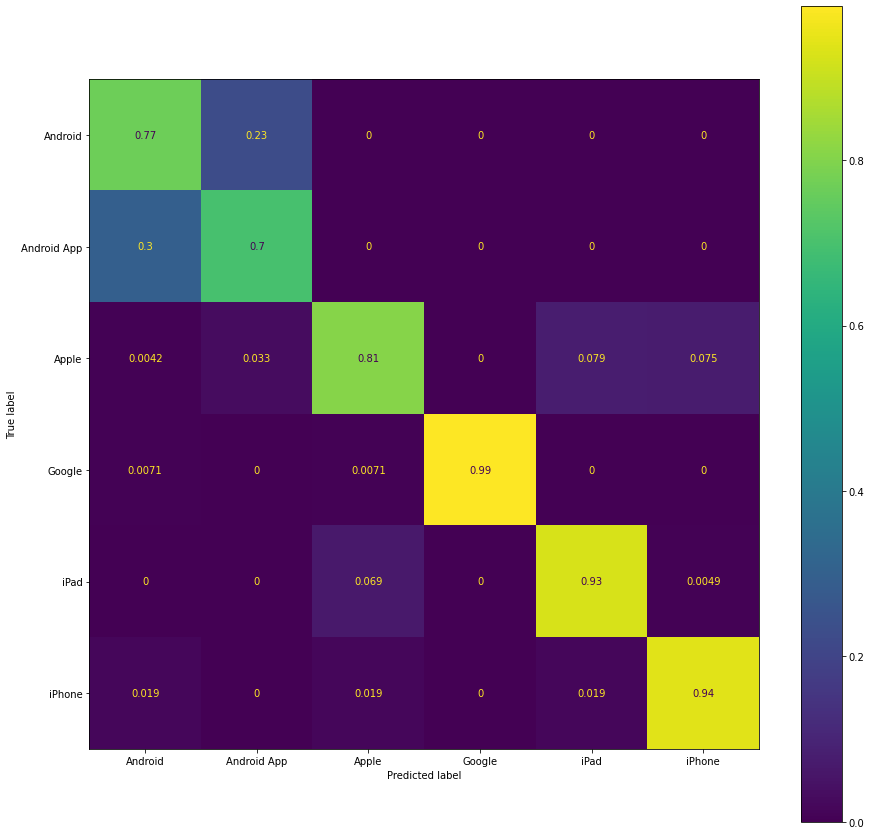

In [507]:
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(15,15))
plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax)

In [510]:
product_df['clean_text'] = product_df['text'].apply(lambda x: ' '.join(clean_text(x)))

In [515]:
product_df

,text,product,target,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,iphone hrs tweet dead need upgrade plugin
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive emotion,know awe ipad iphone app likely appreciate free
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative emotion,hope year cra year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great fri mari mayer google tim o'reilly tech ...
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,guy convince iphone great coverage prince
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quot;papyru like ipad&quot nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Google,Negative emotion,diller google quot;might run play ready today....
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,Positive emotion,camera+ iphone image mode ipad cam app feature


Text(0.5, 1.0, 'Positive Words')

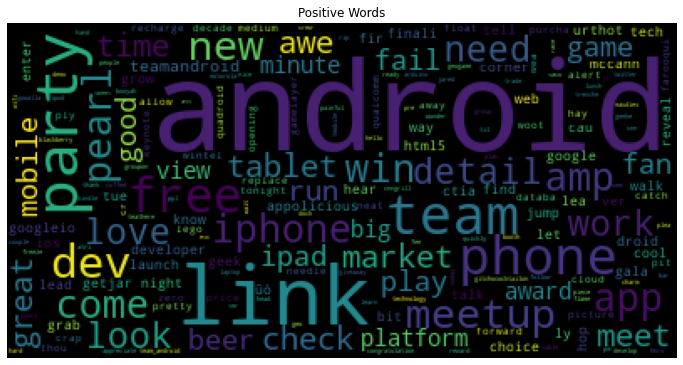

In [512]:
wordcloud = WordCloud(collocations=False)
wordcloud.generate(','.join(product_df[(product_df['product']=='Android')]['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')

Text(0.5, 1.0, 'Positive Words')

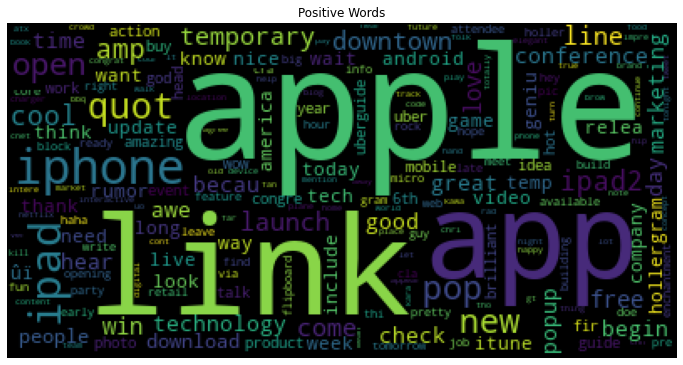

In [513]:
wordcloud = WordCloud(collocations=False)
wordcloud.generate(','.join(product_df[(product_df['product']=='Apple')]['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')

Text(0.5, 1.0, 'Positive Words')

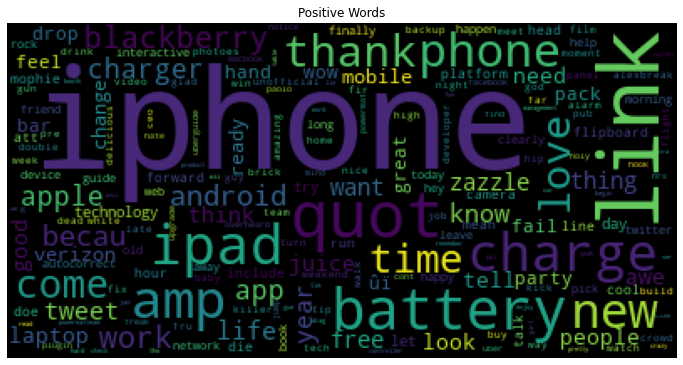

In [516]:
wordcloud = WordCloud(collocations=False)
wordcloud.generate(','.join(product_df[(product_df['product']=='iPhone')]['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')